<center> <h1>PREDICIÓN DEL SUEÑO CON SVM LINEAL BINARIO</h1> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza seco</h4> </center>


###### Índice de contenidos

En este jupyter notebook se lleva a cabo la construcción de un clasificador SVM lineal de salida binaria para predecir el estado de vigilia y sueño de distintos sujetos.
    
    1. Clasificador SVM lineal Binario
        1.1 Preparación datos de entrada y salida
        1.2 Creación del modelo y selección parámetros libres
        1.3 Búsqueda de parámetros con validación cruzada
        1.4 Evaluación del modelo
        1.5 Visualización de resultados

In [1]:
import os
import random
import numpy as np
import pandas as pd
from random import sample
import statistics as stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV

## 1. SVM LINEAL BINARIO

En este clasificador, se ha utilizado el método SVM lineal para clasificar la vigilia o sueño ligero del sueño profundo. Es decir, se ha construido un clasificador SVM con salida binaria: 0 y 1.

### 1.1 Preparación datos de entrada y salida

In [2]:
Train_bin= pd.read_csv('Train.csv')
Test_bin= pd.read_csv('Test.csv')

In [3]:
X_train_bin=Train_bin.drop(['Etiquetas multiclase', 'Etiquetas binarias','ID'], axis = 1) 
y_train_bin=Train_bin['Etiquetas binarias']

# SELECCIÓN 1 PACIENTE
ids= Test_bin['ID']
pacientes=list(set(ids))
paciente=random.choice(pacientes)

X_test_bin=Test_bin.drop(['Etiquetas multiclase'], axis = 1)
X_test_bin = X_test_bin.drop(X_test_bin[X_test_bin['ID']!=paciente].index)
y_test_bin=X_test_bin['Etiquetas binarias']
X_test_bin = X_test_bin.drop(['ID','Etiquetas binarias'],axis=1)

### 1.2  Creación del modelo y selección parámetros libres

In [4]:
clf = SVC(kernel='linear', decision_function_shape='ovr' ) 
modelo_base=clf.fit(X_train_bin,y_train_bin)

In [5]:
clf

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### 1.3  Búsqueda de parámetros con validación cruzada

A continuación, se realiza la búsqueda del parámetro C. Se hace un 'barrido' de los posibles valores del parámetro para elegir aquel que maximice la exactitud (accuracy).

Tras varias iteraciones se ha visto que el mejor parámetro es C=100 para el clasificador SVM lineal binario.

In [6]:
Cs =[0.1,1,10,100,1000] 
param_grid = {'C': Cs} 
svc_grid = GridSearchCV(clf, param_grid, scoring='accuracy',cv=5,n_jobs=-1)
svc_grid.fit(X_train_bin, y_train_bin)
best_param=svc_grid.best_params_

In [7]:
# Clasificador con los mejores parámetros
svc_clf=svc_grid.best_estimator_

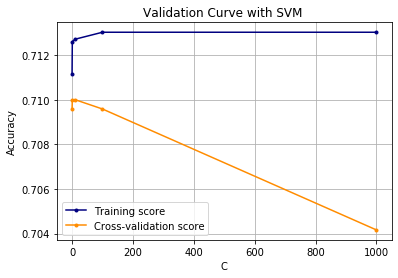

In [8]:
train_scores, test_scores = validation_curve(clf, X_train_bin, y_train_bin, param_name="C", param_range=Cs,cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.title("Validation Curve with SVM ")
plt.xlabel('C')
plt.ylabel("Accuracy")

plt.plot(Cs, train_scores_mean, label="Training score",color="navy",marker='.')
plt.plot(Cs, test_scores_mean, label="Cross-validation score",color="darkorange",marker='.')
plt.grid()
plt.legend(loc="best")
plt.show()

In [9]:
print("El valor más óptimo para el parámetro a estimar es:",best_param)

El valor más óptimo para el parámetro a estimar es: {'C': 1}


In [10]:
print("Tasa de acierto del modelo base:",modelo_base.score(X_test_bin,y_test_bin))
print("Tasa de acierto del modelo con la búsqueda de parámetros:",svc_clf.score(X_test_bin,y_test_bin))
print('Mejora  del {:0.2f}%.'.format( 100 * (svc_clf.score(X_test_bin,y_test_bin) - modelo_base.score(X_test_bin,y_test_bin)) / modelo_base.score(X_test_bin,y_test_bin)))

Tasa de acierto del modelo base: 0.68
Tasa de acierto del modelo con la búsqueda de parámetros: 0.68
Mejora  del 0.00%.


### 1.4 Evaluación del modelo

In [11]:
predict = svc_clf.predict(X_test_bin)

acc_test= svc_clf.score(X_test_bin, y_test_bin).round(4)
acc_train= svc_clf.score(X_train_bin, y_train_bin).round(4)
print('La exactitud para el modelo de SVM en el conjunto de TEST es:',acc_test,'%\n')
print('La exactitud para el modelo de SVM en el conjunto de TRAIN es:',acc_train,'%\n')

print("=============== Classification Report ================")
print(classification_report(y_test_bin, predict))

La exactitud para el modelo de SVM en el conjunto de TEST es: 0.68 %

La exactitud para el modelo de SVM en el conjunto de TRAIN es: 0.7117 %

=============== Classification Report ================
              precision    recall  f1-score   support

         0.0       0.50      0.06      0.11        32
         1.0       0.69      0.97      0.80        68

    accuracy                           0.68       100
   macro avg       0.59      0.52      0.46       100
weighted avg       0.63      0.68      0.58       100



In [12]:
matriz_confusion=pd.crosstab (y_test_bin,predict, rownames=['Clase predicha'], colnames=['Resultado del clasificador'])
matriz_confusion

Resultado del clasificador,0.0,1.0
Clase predicha,,
0.0,2,30
1.0,2,66


### 1.5 Visualización de resultados
A continuación se muestra un ejemplo de las fases del sueño predichas frente a las reales. Para facilitar esta visualización, se muestran la mitad de la muestras del subconjunto de test. 

In [13]:
y_test_bin=list(y_test_bin)

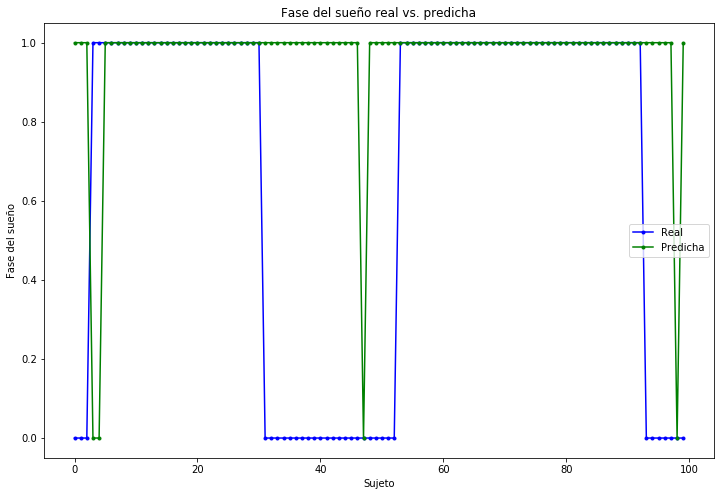

In [14]:
plt.figure(figsize=(12,8))
plt.plot(y_test_bin,color='blue', marker='.',label='Real')
plt.plot(predict,color='green', marker='.',label='Predicha')

plt.title('Fase del sueño real vs. predicha')
plt.xlabel('Sujeto')
plt.ylabel('Fase del sueño')
plt.legend()

**Residuos**

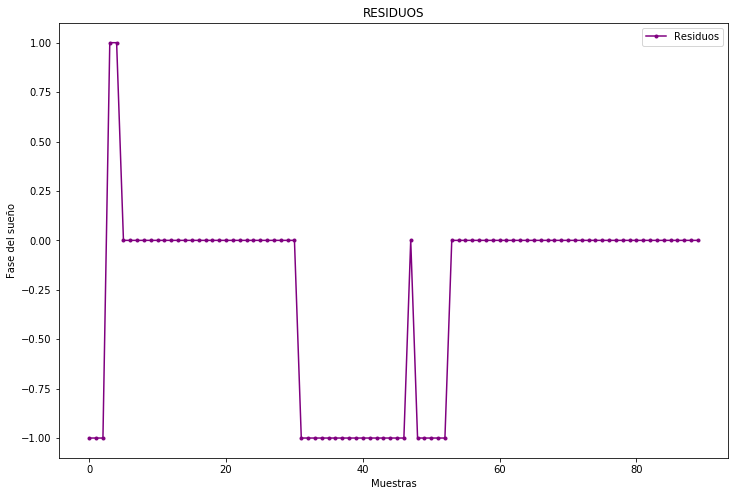

In [15]:
residuos= y_test_bin - predict
plt.figure(figsize=(12,8))
plt.plot(residuos[0:90],color='purple', marker='.',label='Residuos')

plt.title('RESIDUOS')
plt.xlabel('Muestras')
plt.ylabel('Fase del sueño')
plt.legend()